In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#import opencv
import cv2
import os

import imageio

In [2]:
import cv2
import os

def get_min_max_frames(video_folder_path):
    min_frames = float('inf')
    max_frames = 0

    # Loop through all files in the directory
    for video_file in os.listdir(video_folder_path):
        video_path = os.path.join(video_folder_path, video_file)
        
        # Ensure the file is a video
        if os.path.isfile(video_path) and video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            # Open the video using OpenCV
            video = cv2.VideoCapture(video_path)
            
            # Get the number of frames in the video
            frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Update min and max frames
            if frames < min_frames:
                min_frames = frames
            if frames > max_frames:
                max_frames = frames
            
            # Release the video capture object
            video.release()
    
    # Return the min and max frame counts
    return min_frames, max_frames

# Example usage:
video_folder = 'Shop DataSet\shop lifters'
min_frames, max_frames = get_min_max_frames(video_folder)
print(f"Min frames: {min_frames}, Max frames: {max_frames}")


Min frames: 100, Max frames: 570


In [3]:
import cv2
import os

def get_min_max_frames(video_folder_path):
    min_frames = float('inf')
    max_frames = 0

    # Loop through all files in the directory
    for video_file in os.listdir(video_folder_path):
        video_path = os.path.join(video_folder_path, video_file)
        
        # Ensure the file is a video
        if os.path.isfile(video_path) and video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            # Open the video using OpenCV
            video = cv2.VideoCapture(video_path)
            
            # Get the number of frames in the video
            frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Update min and max frames
            if frames < min_frames:
                min_frames = frames
            if frames > max_frames:
                max_frames = frames
            
            # Release the video capture object
            video.release()
    
    # Return the min and max frame counts
    return min_frames, max_frames

# Example usage:
video_folder = 'Shop DataSet/non shop lifters'
min_frames, max_frames = get_min_max_frames(video_folder)
print(f"Min frames: {min_frames}, Max frames: {max_frames}")


Min frames: 75, Max frames: 1850


# Load Data

In [4]:
def Frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=2):
    ''' 
    Creates frames from each video file present for each category.
    '''
    if not os.path.exists(video_path):
        print(f"Error: The video file at {video_path} does not exist.")
        return None

    result = []
    src = cv2.VideoCapture(video_path)

    if not src.isOpened():
        print(f"Error: Could not open video file {video_path}.")
        return None

    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_length == 0:
        print(f"Error: The video file {video_path} has no frames.")
        return None

    need_length = 1 + (n_frames - 1) * frame_step
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = np.random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)

    # Read the first frame
    ret, frame = src.read()

    if ret and frame is not None:
        print(f"First frame shape: {frame.shape}, dtype: {frame.dtype}")  # Debug print
        result.append(format_frames(frame, output_size))
    else:
        print(f"Warning: Could not read the first frame from {video_path}")
        return None

    # Read the remaining frames
    for i in range(n_frames - 1):
        for j in range(frame_step):
            ret, frame = src.read()
        if ret and frame is not None:
            print(f"Read frame shape: {frame.shape}, dtype: {frame.dtype}")  # Debug print
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            print(f"Warning: Could not read frame at index {i} from {video_path}")
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]  # Convert BGR to RGB

  

    return result


In [5]:
def format_frames(frame,output_size):
    '''
    pad and resizes the frame

    args:
    frame: frame to be resized
    output_size: size of the output frame

    returns:
    resized and normalized frame
    '''
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [6]:
# Create a function to process all videos in a folder
def process_videos_from_folder(folder_path, label, n_frames, output_size=(224, 224), frame_step=2):
    video_data = []
    video_labels = []

    for video_file in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video_file)
        
        # Check if the file is a video 
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            # Extract frames from the video
            frames = Frames_from_video_file(video_path, n_frames, output_size, frame_step)
            
            # Append the frames and the label to the lists
            video_data.append(frames)
            video_labels.append(label)
    
    return np.array(video_data), np.array(video_labels)

In [7]:
shoplifting_folder = 'Shop DataSet/shop lifters'
non_shoplifting_folder = 'Shop DataSet/non shop lifters'

# Number of frames to extract from each video
n_frames = 32

# Extract frames from both folders
shoplifting_videos, shoplifting_labels = process_videos_from_folder(shoplifting_folder, label=1, n_frames=n_frames)
non_shoplifting_videos, non_shoplifting_labels = process_videos_from_folder(non_shoplifting_folder, label=0, n_frames=n_frames)

# Combine the data and labels from both categories
all_videos = np.concatenate([shoplifting_videos, non_shoplifting_videos], axis=0)
all_labels = np.concatenate([shoplifting_labels, non_shoplifting_labels], axis=0)

print(f'Total videos: {len(all_videos)}, Labels: {len(all_labels)}')

First frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), 

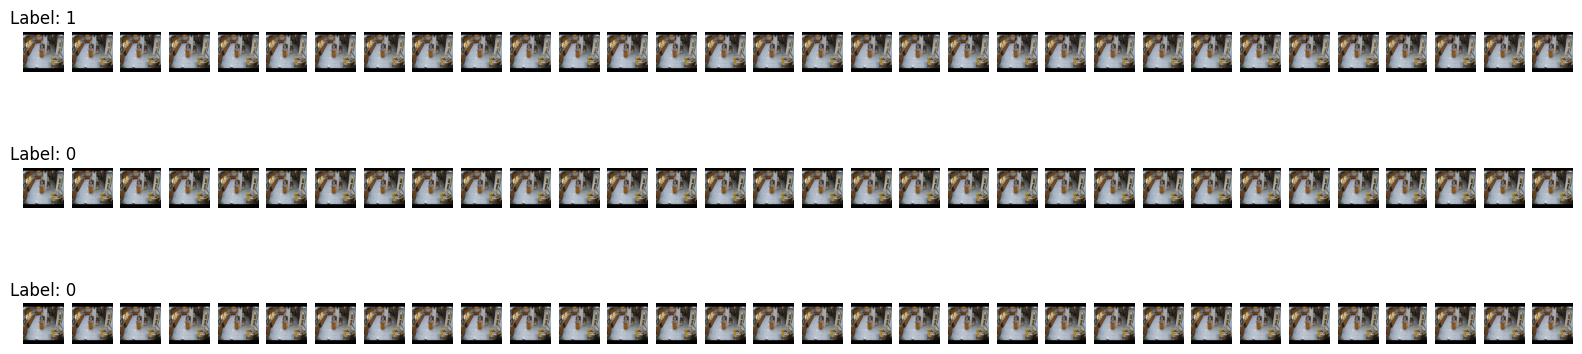

In [8]:

def plot_sample_frames(videos, labels, n_samples=3):
    ''' 
    Plot a sample of frames from the video dataset.
    
    Args:
    videos: list of video frames
    labels: corresponding labels
    n_samples: number of samples to plot
    '''
    fig, axs = plt.subplots(n_samples, n_frames, figsize=(20, 5))
    
    for i in range(n_samples):
        video_idx = np.random.randint(0, len(videos))
        for j in range(n_frames):
            axs[i, j].imshow(videos[video_idx][j])
            axs[i, j].axis('off')
        
        axs[i, 0].set_title(f'Label: {labels[video_idx]}')

    plt.show()

# Plot a sample of videos with their labels
plot_sample_frames(all_videos, all_labels)

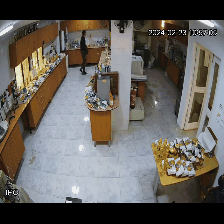

In [9]:
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display

def to_gif(images):
    '''
    Creates GIF from the frames.

    Args:
    images: frames to be converted to gif.

    Returns:
    gif (displayed inline).
    '''
    
    # Convert images to the range [0, 255] and clip to ensure valid pixel values
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    
    # Calculate duration from fps (e.g., 10 fps -> 100 ms per frame)
    duration = 1000/ 10  # 10 fps
    
    # Save the GIF using duration instead of fps
    imageio.mimsave('./animation.gif', converted_images, duration=duration)  
    
    # Display the GIF
    display(Image(filename='./animation.gif'))

# Create a GIF from the first video frames
to_gif(all_videos[6])


In [10]:
# Print the shape of the first video in the 'all_videos' array
print(f"Shape of the first video: {all_videos[2].shape}")


Shape of the first video: (32, 224, 224, 3)


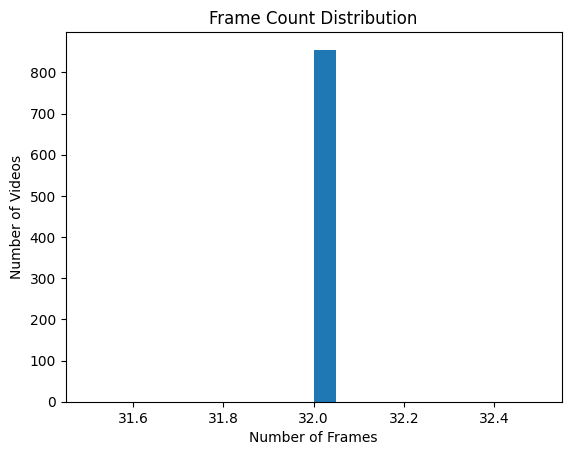

In [11]:
import matplotlib.pyplot as plt
frame_counts = [video.shape[0] for video in all_videos]
plt.hist(frame_counts, bins=20)
plt.title('Frame Count Distribution')
plt.xlabel('Number of Frames')
plt.ylabel('Number of Videos')
plt.show()


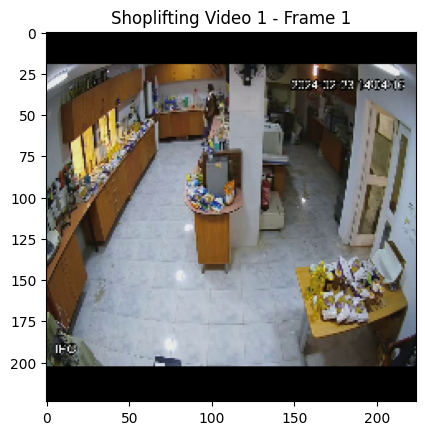

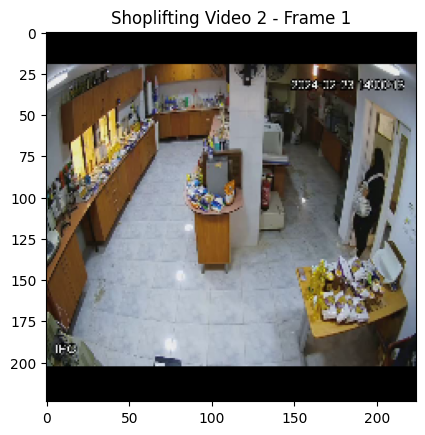

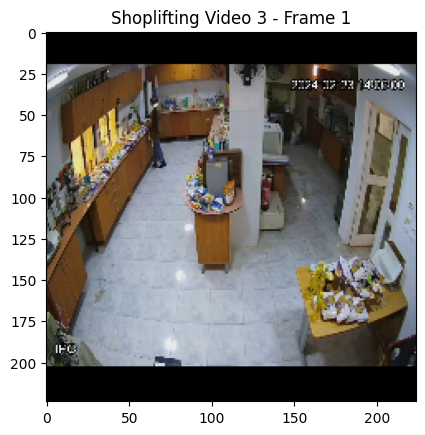

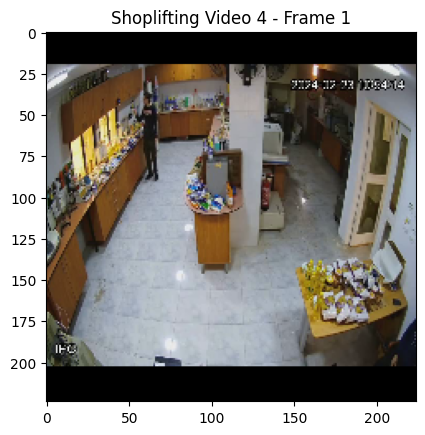

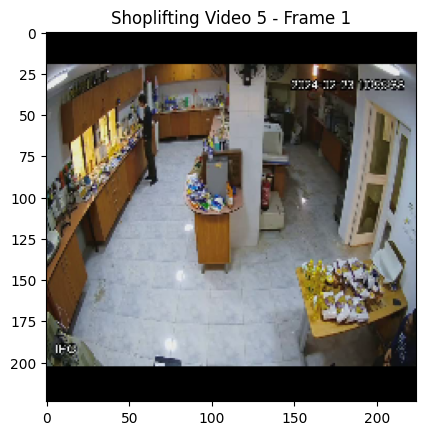

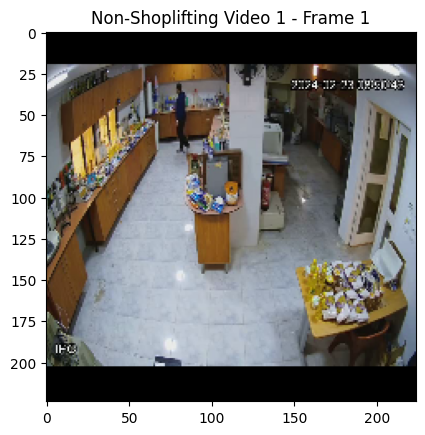

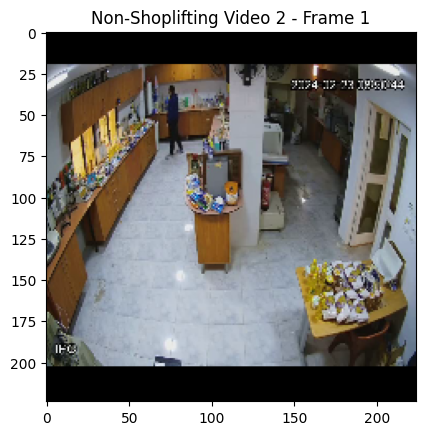

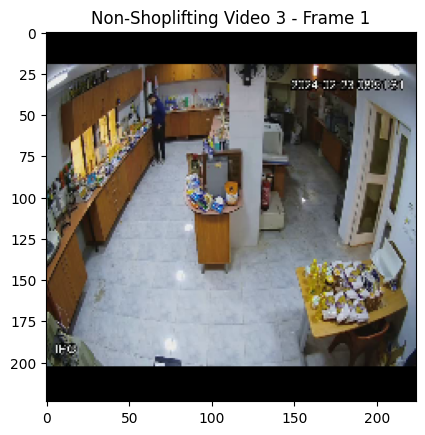

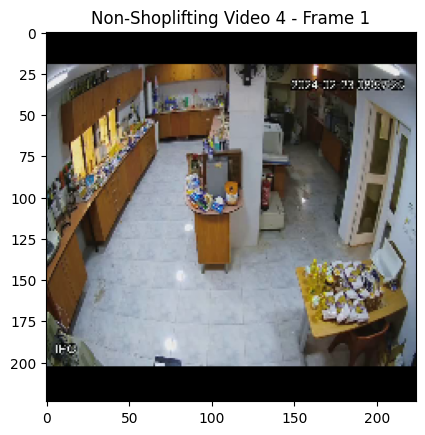

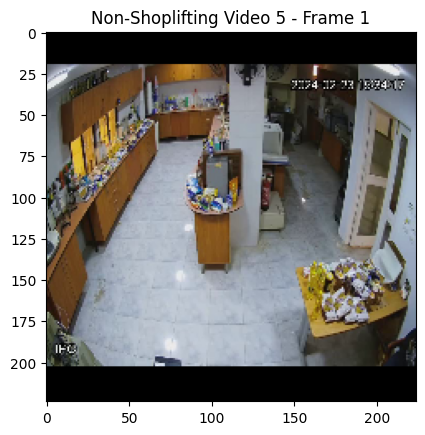

In [12]:
# Plot sample frames from shoplifting videos
for i in range(5):  # First 5 videos from the shoplifting category
    plt.imshow(all_videos[i][0])  # Visualize the first frame
    plt.title(f'Shoplifting Video {i+1} - Frame 1')
    plt.show()

# Plot sample frames from non-shoplifting videos
for i in range(5):
    plt.imshow(all_videos[len(shoplifting_videos) + i][0])  # First frame from non-shoplifting videos
    plt.title(f'Non-Shoplifting Video {i+1} - Frame 1')
    plt.show()


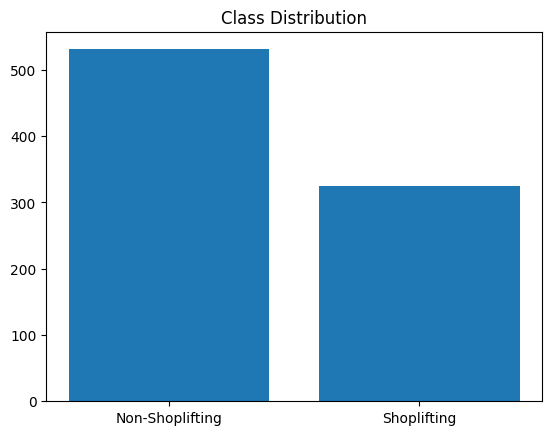

In [15]:
import numpy as np
unique, counts = np.unique(all_labels, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1], ['Non-Shoplifting', 'Shoplifting'])
plt.title('Class Distribution')
plt.show()
